In [4]:
from mpl_toolkits import mplot3d
from scipy.interpolate import CubicSpline
import scipy.io as scio
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

data = scio.loadmat('../Data/tissue3_1.mat')

In [5]:
# Look at imported data
#for key, value in data8.items():
 #   print(key)

t3  = data['map_t3']

## Baseline removal

In [6]:
def remove_baseline(spectrum, window_size=64):
    """
    Use rubber-band method to remove baseline from spectrum
    Input:  - spectrum: np.array
            - window_size (optional): size of rubber-band window
    Output: - smoothed_spectrum: spectrum after baseline removal
    """
    spectrum_len = len(spectrum)  
    num_intervals = int(spectrum_len//window_size)
    
    # Get min value at each interval
    min_values = []
    min_indexes = []
    
    for k in range(int(num_intervals)):
        min_value = np.amin(spectrum[window_size*k : window_size*(k+1)])
        min_index = np.argmin(spectrum[window_size*k : window_size*(k+1)]) + window_size*k
        min_values.append(min_value)
        min_indexes.append(min_index)

    min_value = np.amin(spectrum[1004 : 1024])
    min_index = np.argmin(spectrum[1004 : 1024]) + 1018
    min_values.append(min_value)
    min_indexes.append(min_index)

    # Fit cubic spline
    cs = CubicSpline(min_indexes,min_values)

    # Remove spline from original spectrum
    smoothed_spectrum = np.zeros(spectrum_len)  
    for i in range(1024):
        smoothed_spectrum[i] = spectrum[i] - cs(i)
            
    return cs, min_indexes,min_values, smoothed_spectrum
        

In [7]:
no_baseline = t3.copy()

for i in range(200):
    for j in range(200):
        smoothed = no_baseline[i,j,:]
        for k in range(4,1020):
            smoothed[k] = np.mean(t3[i,j,k-4:k+4])
        
        cs, _, _, _ = remove_baseline(smoothed)
        for k in range(1024):
            no_baseline[i,j,k] = no_baseline[i,j,k] - cs(k)


# PCA analysis

In [8]:
D = np.zeros((40000,1024))

for i in range(200):
    for j in range(200):
        index = i*200 + j
        D[index,:] = no_baseline[i,j,:]

In [9]:
pca = PCA(n_components=10)
pca.fit_transform(D.T)
comp = pca.components_

In [10]:
import pandas as pd
loadings = pd.DataFrame(comp.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                                                        index=[str(i) for i in range(40000)])
loadings

ValueError: Shape of passed values is (40000, 10), indices imply (40000, 5)

In [ ]:
var = comp.T * np.sqrt(pca.explained_variance_)
#loading_matrix = pd.DataFrame(var, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                                                        #index=[str(i) for i in range(40000)])
#loading_matrix

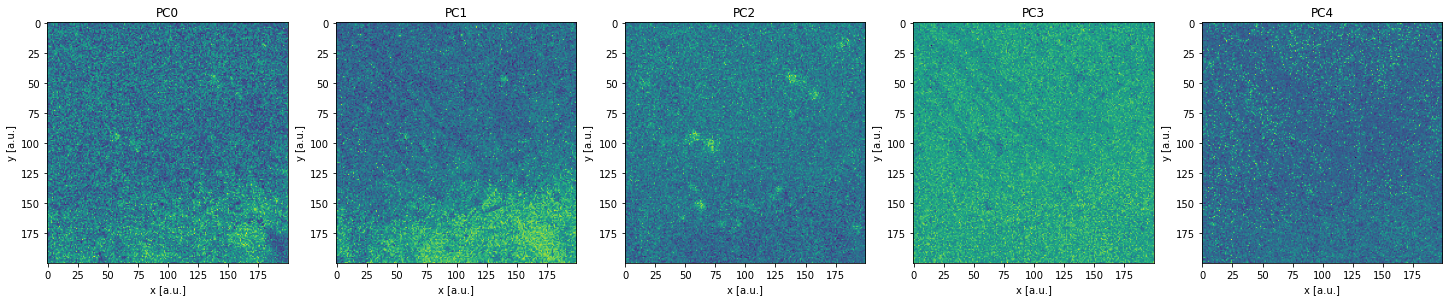

In [ ]:
result = np.zeros((200,200,5))

_, axs = plt.subplots(1,5, figsize=(25,10))

for k in range(5):
    for i in range(200):
        for j in range(200):
            index = i*200 + j
            result[i,j,k] = var[index,k]
    axs[k].imshow(result[:,:,k])
    axs[k].title.set_text('PC'+str(k))
    axs[k].set_xlabel('x [a.u.]')
    axs[k].set_ylabel('y [a.u.]')

Pre-processing steps:
1. Remove spikes in each spectrum (derivative-based method)
2. Wavenumber calibration (use 4-acetamedophenol)
3. Baseline correction (Alternative Least Squares)
4. Truncate spectra 
5. Vector normalisation

Then, average spectra belonging to each group.

## K-means

In [ ]:
def find_kmean(data, clusters=2):
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(data)
    data_labels = kmeans.labels_
    kmeans_labels = np.zeros((200,200))

    for i in range(200):
        for j in range(200):
            index = i*200 + j
            kmeans_labels[i,j] = data_labels[index]
    return kmeans_labels

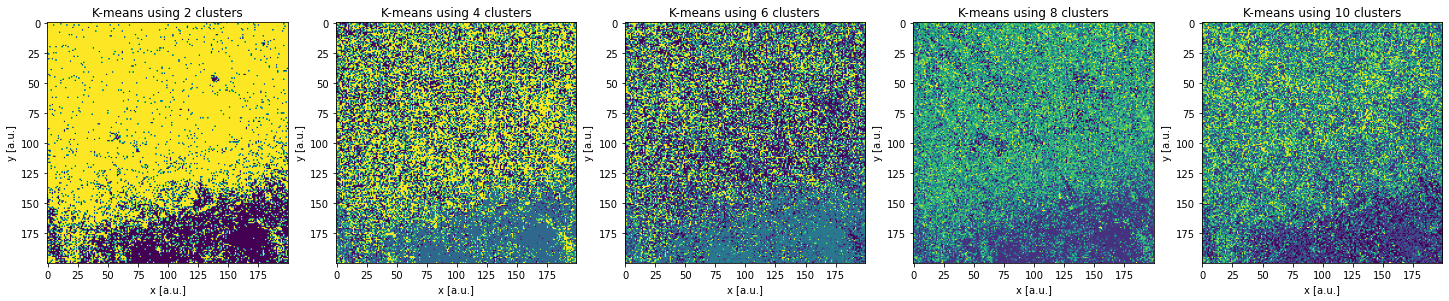

In [ ]:
# var has dimensions (40000,5)
_, axs = plt.subplots(1,5, figsize=(25,10))

for k in range(1,6):
    kmean = find_kmean(var,k*2) 
    axs[k-1].imshow(kmean) 
    axs[k-1].title.set_text('K-means using '+str(k*2)+ ' clusters')
    axs[k-1].set_xlabel('x [a.u.]')
    axs[k-1].set_ylabel('y [a.u.]')